In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(1)
np.random.seed(1)

In [3]:
BATCH_SIZE = 50
LR = 0.001              # learning rate

In [6]:
mnist = input_data.read_data_sets('./mnist', one_hot=True)  # they has been normalized to range (0,1)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

Extracting ./mnist\train-images-idx3-ubyte.gz
Extracting ./mnist\train-labels-idx1-ubyte.gz
Extracting ./mnist\t10k-images-idx3-ubyte.gz
Extracting ./mnist\t10k-labels-idx1-ubyte.gz


In [10]:
print(test_x.shape)
print(test_y.shape)
test_y

(2000, 784)
(2000, 10)


array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(55000, 784)
(55000, 10)


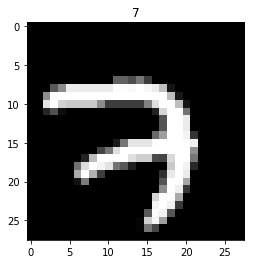

In [11]:
# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)   # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0])); plt.show()

In [12]:
tf_x = tf.placeholder(tf.float32, [None, 28*28]) / 255.
image = tf.reshape(tf_x, [-1, 28, 28, 1])              # (batch, height, width, channel)
tf_y = tf.placeholder(tf.int32, [None, 10])            # input y

In [13]:
# CNN
conv1 = tf.layers.conv2d(   # shape (28, 28, 1)
    inputs=image,
    filters=16,
    kernel_size=5,
    strides=1,
    padding='same',
    activation=tf.nn.relu
)           # -> (28, 28, 16)

In [14]:
pool1 = tf.layers.max_pooling2d(
    conv1,
    pool_size=2,
    strides=2,
)           # -> (14, 14, 16)

In [15]:
conv2 = tf.layers.conv2d(pool1, 32, 5, 1, 'same', activation=tf.nn.relu)    # -> (14, 14, 32)

In [16]:
pool2 = tf.layers.max_pooling2d(conv2, 2, 2)    # -> (7, 7, 32)

In [17]:
flat = tf.reshape(pool2, [-1, 7*7*32])          # -> (7*7*32, )

In [18]:
output = tf.layers.dense(flat, 10)              # output layer

In [19]:
loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost

In [20]:
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

In [21]:
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

In [22]:
sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
sess.run(init_op)     # initialize var in graph

In [23]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')
def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

Step: 0 | train loss: 2.3390 | test accuracy: 0.15


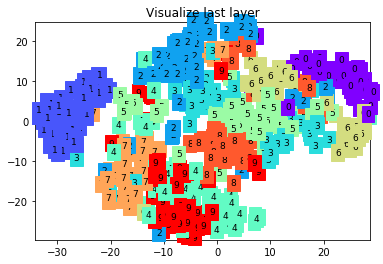

Step: 50 | train loss: 0.4649 | test accuracy: 0.49


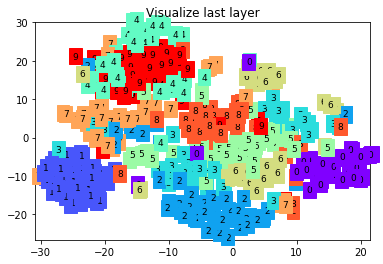

Step: 100 | train loss: 0.2110 | test accuracy: 0.62


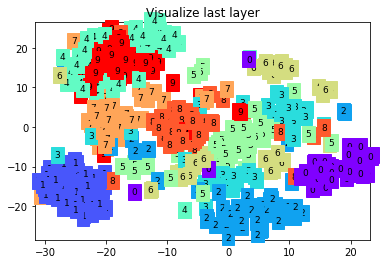

Step: 150 | train loss: 0.2144 | test accuracy: 0.69


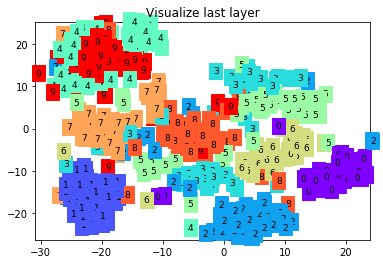

Step: 200 | train loss: 0.1929 | test accuracy: 0.74


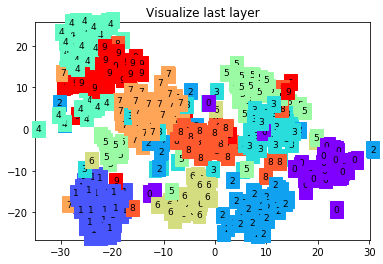

Step: 250 | train loss: 0.1939 | test accuracy: 0.78


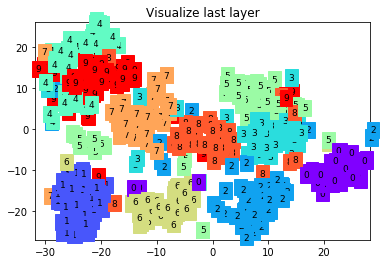

Step: 300 | train loss: 0.0868 | test accuracy: 0.80


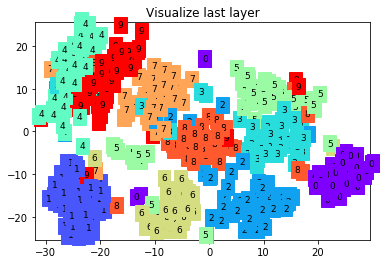

Step: 350 | train loss: 0.0724 | test accuracy: 0.82


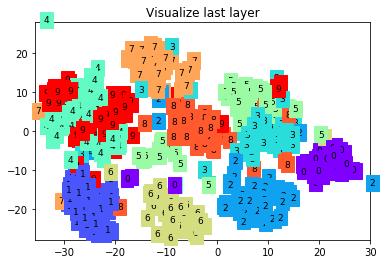

Step: 400 | train loss: 0.1010 | test accuracy: 0.83


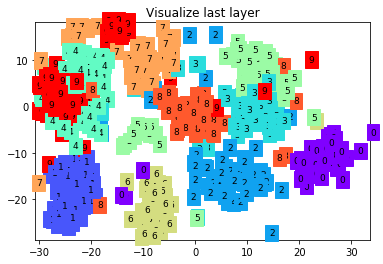

Step: 450 | train loss: 0.0986 | test accuracy: 0.85


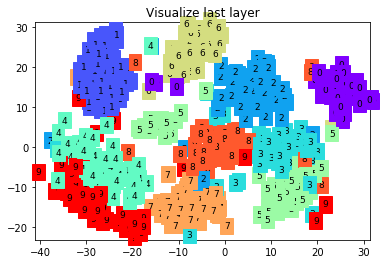

Step: 500 | train loss: 0.2069 | test accuracy: 0.86


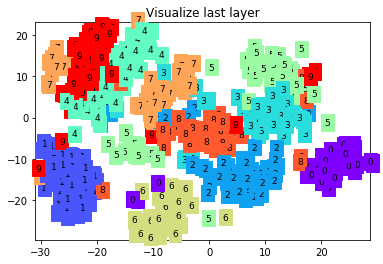

Step: 550 | train loss: 0.1174 | test accuracy: 0.86


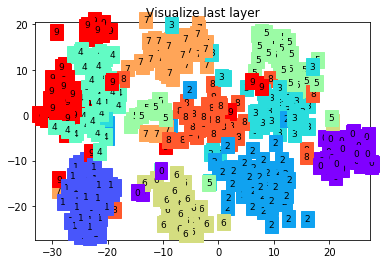

In [24]:
plt.ion()
for step in range(600):
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    if step % 50 == 0:
        accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
        print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

        if HAS_SK:
            # Visualization of trained flatten layer (T-SNE)
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = 500
            low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
            labels = np.argmax(test_y, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [25]:
# print 10 predictions from test data
test_output = sess.run(output, {tf_x: test_x[:10]})
pred_y = np.argmax(test_output, 1)
print(pred_y, 'prediction number')
print(np.argmax(test_y[:10], 1), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [26]:
test_output

array([[ -6.15046883,  -6.74433327,  -1.97103274,   0.36215207,
        -11.19134521,  -5.85158777, -16.67971611,  12.11077213,
         -5.47061491,  -2.00453806],
       [  0.94768906,   0.20897895,   9.76771069,  -5.18549156,
        -15.6873579 ,  -8.92016983,  -3.84643245, -16.2100296 ,
         -2.36728621, -20.6810894 ],
       [ -3.6144886 ,   5.79706669,  -2.48696709,  -3.03018641,
         -0.62857676,  -4.96806717,  -0.59346139,  -2.0112474 ,
         -1.12910616,  -3.08462739],
       [  9.00946712, -12.90360928,  -3.03798842, -10.3066864 ,
         -7.64659643,  -3.8664434 ,  -0.98642325,  -3.25242019,
         -6.58819866,  -5.73076677],
       [ -4.90428257,  -6.77197838,  -5.67055511,  -7.20554686,
          8.13609791,  -6.31342411,  -3.67619205,  -1.56675315,
         -3.9193933 ,   0.78038406],
       [ -4.28454065,   6.30054522,  -3.62684774,  -3.62317491,
         -0.46360558,  -6.74769354,  -2.24690866,  -0.92443943,
         -0.8588587 ,  -3.0983882 ],
       [-1

In [28]:
test_y

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])